In [1]:
import numpy as np
from skimage.util.shape import view_as_windows
from skimage import io, color, img_as_float, img_as_ubyte,exposure
import glob, os
import matplotlib.pyplot as plt
import tkinter
from tkinter.filedialog import askdirectory

In [2]:
def estimate_background(img, preset_indices=None, window_shape=(16, 16, 3), step=4):
    img_windows = view_as_windows(img, window_shape, step)
    img_windows_flat = np.reshape(img_windows, (img_windows.shape[0]*img_windows.shape[1], img_windows.shape[3], img_windows.shape[4],  img_windows.shape[5]))
    if preset_indices is None:
        s_windows = np.sum(img_windows_flat, axis=(1, 2, 3))
        indices = np.argsort(s_windows) # ascending 
        a = int(img_windows_flat.shape[0]*0.0001)
        low_indices = indices[-a:]
    else:
        low_indices = preset_indices
    low_patches = img_windows_flat[low_indices]
    bg_mean = np.mean(low_patches, axis=(0, 1, 2))
    return bg_mean, low_indices

In [3]:
### set path
root = tkinter.Tk()
dirname = askdirectory(parent=root, initialdir="/",
                                    title='Please select a directory')
dataset_base = dirname
bg_path = os.path.join(dataset_base, 'bg')
pos_path = os.path.join(dataset_base, '+5')
neg_path = os.path.join(dataset_base, '-5')
result_path = os.path.join(dataset_base, 'results')
os.makedirs(result_path, exist_ok=True)
if not os.path.exists(pos_path) and os.path.exists(neg_path):
    print('Negative or positive image folders not found')
root.destroy()

In [4]:
file_pos = [os.path.join(pos_path, f) for f in os.listdir(pos_path)]
file_pos.sort()
file_neg = [os.path.join(neg_path, f) for f in os.listdir(neg_path)]
file_neg.sort()
if len(file_neg)==0 or len(file_pos)==0 or len(file_neg)!=len(file_pos):
    print('Negative or positive images not matched')

In [10]:
for i in range(0, len(file_pos)):
    if os.path.exists(bg_path):
        img_pos = img_as_float(io.imread(os.path.join(bg_path, 'b+5.tif')))
        img_neg = img_as_float(io.imread(os.path.join(bg_path, 'b-5.tif')))
    else:
        img_pos = img_as_float(io.imread(file_pos[i]))
        img_neg = img_as_float(io.imread(file_neg[i]))
    pos_v = np.concatenate(img_pos).sum()
    neg_v = np.concatenate(img_neg).sum()
    if pos_v > neg_v:        
        bg_pos_mean, indices = estimate_background(img_pos)
        bg_neg_mean, _ = estimate_background(img_neg, preset_indices=indices)
    else:
        bg_neg_mean, indices = estimate_background(img_neg)
        bg_pos_mean, _ = estimate_background(img_pos, preset_indices=indices)
    bg_pos_max = np.max(bg_pos_mean)
    bg_neg_max = np.max(bg_neg_mean)
    a_pos = max(bg_pos_max, bg_neg_max) / bg_pos_max
    a_neg = max(bg_pos_max, bg_neg_max) / bg_neg_max
    bg_pos_mean = bg_pos_max / bg_pos_mean
    bg_neg_mean = bg_neg_max / bg_neg_mean
    cor_img_pos = np.clip(img_pos * bg_pos_mean * a_pos, 0, 1)
    cor_img_neg = np.clip(img_neg * bg_neg_mean * a_neg, 0, 1)
    pos_neg = np.clip(cor_img_pos - cor_img_neg, 0, 1)
    img_max = max(pos_neg.flatten())
    neg_pos = np.clip(cor_img_neg - cor_img_pos, 0, 1)
    img_max = max(neg_pos.flatten())
    result_img = np.clip(pos_neg+neg_pos, 0, 1)
    io.imsave(os.path.join(result_path, str(i+1)+'.tif'), img_as_ubyte(result_img))
    gray = np.amax(result_img, 2)
    io.imsave(os.path.join(result_path, str(i+1)+'_gray.tif'), img_as_ubyte(gray))

In [15]:
for i in range(0, len(file_pos)):
    img_pos = img_as_float(io.imread(file_pos[0]))
    img_neg = img_as_float(io.imread(file_neg[0]))
    pos_v = np.concatenate(img_pos).sum()
    neg_v = np.concatenate(img_neg).sum()
    if pos_v > neg_v:        
        bg_pos_mean, indices = estimate_background(img_pos)
        bg_neg_mean, _ = estimate_background(img_neg, preset_indices=indices)
    else:
        bg_neg_mean, indices = estimate_background(img_neg)
        bg_pos_mean, _ = estimate_background(img_pos, preset_indices=indices)
    bg_pos_max = np.max(bg_pos_mean)
    bg_neg_max = np.max(bg_neg_mean)
    a_pos = max(bg_pos_max, bg_neg_max) / bg_pos_max
    a_neg = max(bg_pos_max, bg_neg_max) / bg_neg_max
    bg_pos_mean = bg_pos_max / bg_pos_mean
    bg_neg_mean = bg_neg_max / bg_neg_mean
    cor_img_pos = np.clip(img_pos * bg_pos_mean * a_pos, 0, 1)
    cor_img_neg = np.clip(img_neg * bg_neg_mean * a_neg, 0, 1)
    pos_c_v = np.concatenate(img_pos).mean()
    neg_c_v = np.concatenate(img_neg).mean()
    if neg_c_v > pos_c_v:
        pos_neg = exposure.rescale_intensity(np.clip(cor_img_pos - cor_img_neg, 0, 1), in_range=(0.1, 0.9), out_range=(0, 1)) 
        neg_pos = exposure.rescale_intensity(np.clip(cor_img_neg - cor_img_pos, 0, 1), in_range=(0.1, 0.9), out_range=(0, 1)) 
    else: 
        neg_pos = exposure.rescale_intensity(np.clip(cor_img_neg - cor_img_pos, 0, 1), in_range=(0.1, 0.9), out_range=(0, 1)) 
        pos_neg = exposure.rescale_intensity(np.clip(cor_img_pos - cor_img_neg, 0, 1), in_range=(0.1, 0.9), out_range=(0, 1)) 
    result_img = np.clip(pos_neg+neg_pos, 0, 1)
    io.imsave(os.path.join(result_path, str(i)+'-5'+'.tif'), img_as_ubyte(neg_pos))
    io.imsave(os.path.join(result_path, str(i)+'+5'+'.tif'), img_as_ubyte(pos_neg))
    io.imsave(os.path.join(result_path, str(i)+'-result'+'.tif'), img_as_ubyte(result_img))
    print('saved pos: '+ str(i))

saved pos: 0
saved pos: 1


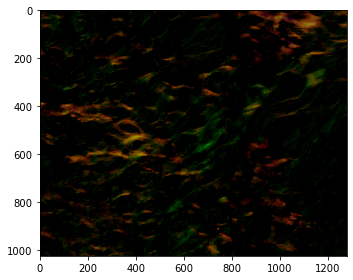

In [7]:
io.imshow(neg_pos)

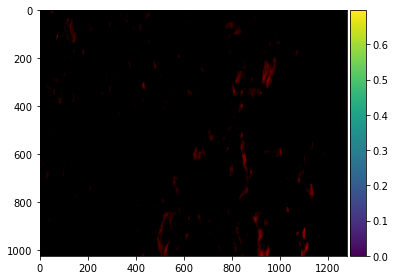

In [8]:
io.imshow(pos_neg)